In [25]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [28]:
def get_balanced_trials(trial_ts, require_both_stim_types=True):
    # Get valid trials (exclude early withdrawals)
    valid_trials = trial_ts[trial_ts.trial_outcome.isin([0,1])]
    
    # Optionally require both stim types
    if require_both_stim_types:
        valid_trials = valid_trials[
            (valid_trials.movement_stims.apply(len) > 0) & 
            (valid_trials.stationary_stims.apply(len) > 0)
        ]
    
    # Find minimum number of trials between conditions
    min_trials = min(
        len(valid_trials[valid_trials.trial_outcome == 1]),
        len(valid_trials[valid_trials.trial_outcome == 0])
    )
    
    # Sample equal numbers from each condition
    balanced_trials = pd.concat([
        valid_trials[valid_trials.trial_outcome == 1].sample(n=min_trials, random_state=42),
        valid_trials[valid_trials.trial_outcome == 0].sample(n=min_trials, random_state=42)
    ])
    
    return balanced_trials, min_trials

In [45]:
binwidth_ms = 10
pre_seconds = 0
post_seconds = 0.15
stim_duration = 0.015
inter_stim_interval = 0.025

balanced_trial_ts, min_trials = get_balanced_trials(trial_ts)
balanced_trial_ts.sort_values(by='first_stim_ts', inplace=True)
first_stims = np.array(balanced_trial_ts.first_stim_ts)

pop_peth, timebin_edges, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=np.hstack(first_stims),
        pre_seconds=pre_seconds,
        post_seconds=post_seconds,
        binwidth_ms=binwidth_ms,
        pad=0,
        kernel=None,
    )

n_units, n_stims, n_timepoints = pop_peth.shape

In [174]:
time_vector = np.arange(first_stims[0], first_stims[-1] + post_seconds, binwidth_ms / 1000)
time = np.zeros(time_vector.shape)
stim_indices = np.searchsorted(time_vector, first_stims)
time[stim_indices] = 1

design_matrix = np.zeros((len(time), n_timepoints))
for i in range(n_timepoints):
    if i < len(time):
        design_matrix[i:, i] = time[:len(time) - i]

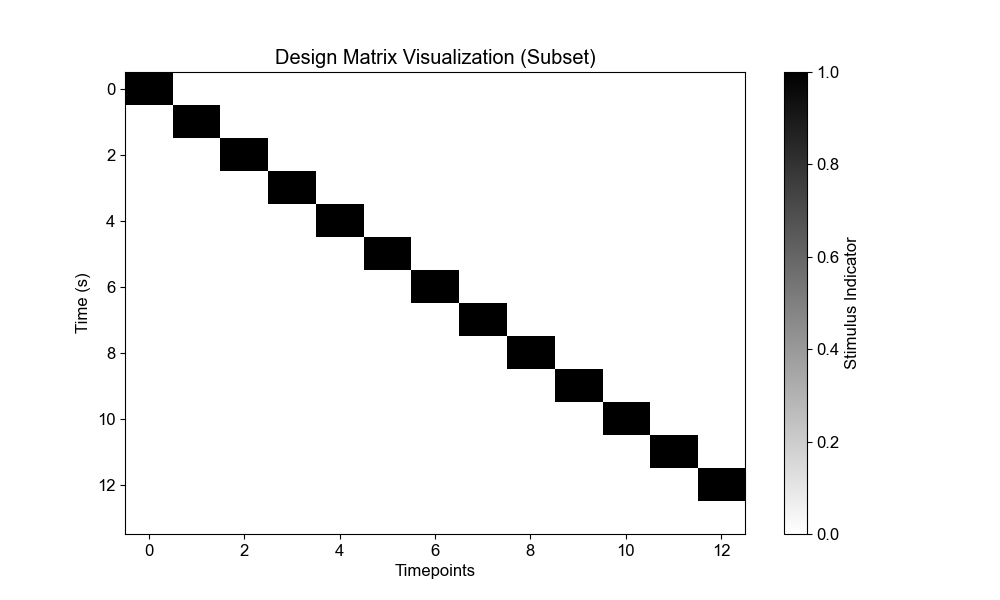

In [175]:
# Define a range to visualize
start_time = 0
end_time = 14 # Adjust this range as needed

# Visualize a subset of the design matrix
plt.figure(figsize=(10, 6))
plt.imshow(design_matrix[start_time:end_time, :], aspect='auto', cmap='gray_r')
plt.colorbar(label='Stimulus Indicator')
plt.xlabel('Timepoints')
plt.ylabel('Time (s)')
plt.title('Design Matrix Visualization (Subset)')
plt.show()

Time Vector: [  88.11508318   88.12508318   88.13508318 ... 4504.54508318 4504.55508318
 4504.56508318]
First Stims: [  88.11508318   94.54921333  127.27913733  132.459904    138.61926133
  142.989484    167.92037067  172.10116933  188.01688444  192.91236133
  197.975864    216.40873733  220.49891067  274.77061867  298.55760133
  302.669088    362.56159333  387.06574206  398.08872929  407.42372133
  428.52027333  438.15650435  442.06288335  475.46737733  534.050764
  558.47219467  576.56633329  650.57475333  662.86961333  669.01292267
  700.59633467  734.45693067  791.8190115   809.177176    828.13257172
  840.600604    884.292892    904.16210133  935.19623333  946.51518933
 1006.207632   1042.68928267 1052.05891067 1058.09296895 1061.425964
 1070.486472   1098.67017636 1123.976916   1138.23950267 1143.22556125
 1164.45192533 1204.18730267 1209.35750737 1216.05809192 1226.76099067
 1238.27447467 1322.90311787 1336.33651867 1352.95614542 1361.59247915
 1372.42076133 1396.45025733 1406.8

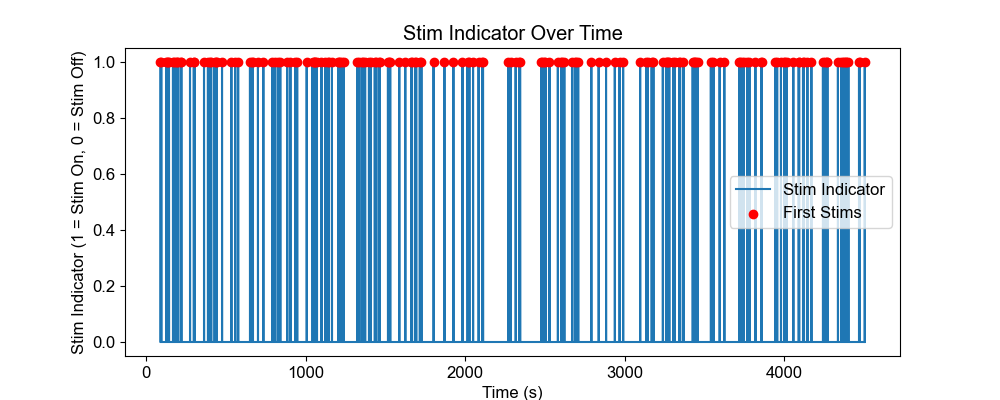

Stim Indices: [     0    644   3917   4435   5051   5488   7981   8399   9991  10480
  10987  12830  13239  18666  21045  21456  27445  29896  30998  31931
  34041  35005  35395  38736  44594  47036  48846  56246  57476  58090
  61249  64635  70371  72107  74002  75249  79618  81605  84709  85841
  91810  95458  96395  96998  97332  98238 101056 103587 105013 105512
 107634 111608 112125 112795 113865 115016 123479 124823 126485 127348
 128431 130834 131875 134487 135184 136918 137638 142741 143281 144159
 149844 153614 157438 157819 159911 160450 162706 163715 171341 178148
 183774 189480 192634 193791 196096 199566 201805 202343 218169 219706
 222801 225092 225591 238848 239240 240565 241481 244000 249243 251434
 252098 253302 258131 259855 260806 261996 270231 274831 279458 284948
 287926 290177 300841 304670 305517 308051 309150 315051 317046 317703
 318380 319094 321688 322590 325319 325880 327996 333764 334540 335439
 336048 336851 345156 346803 350661 353598 362945 363391 364638

In [176]:
# Step 1: Print the time_vector and first_stims
print("Time Vector:", time_vector)
print("First Stims:", first_stims)

# Step 2: Visualize the Result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(time_vector, time, label='Stim Indicator', drawstyle='steps-post')
plt.scatter(first_stims, np.ones_like(first_stims), color='red', label='First Stims', zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('Stim Indicator (1 = Stim On, 0 = Stim Off)')
plt.title('Stim Indicator Over Time')
plt.legend()
plt.show()

# Step 3: Check Indices
print("Stim Indices:", stim_indices)

# Optional: Step 4: Compare with expected output if you have known stim times
# known_stim_times = [your_known_stim_times]  # Replace with your known values
# print("Expected Stim Times:", known_stim_times)

In [7]:
n_units, n_stims, n_timepoints = pop_peth.shape

y = pop_peth.reshape(n_units, n_stims*n_timepoints)

#sklearn expects time to be the first dimension
y = y.T
X = np.tile(np.eye(n_timepoints), (n_stims, 1))

print(X.shape, y.shape)
assert y.shape[0] == X.shape[0]

(5759, 13) (5759, 182)


In [8]:
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
#let's implement some cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model = LinearRegression()
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(scores.mean())

model.fit(X, y)

0.014081334913189752


LinearRegression()

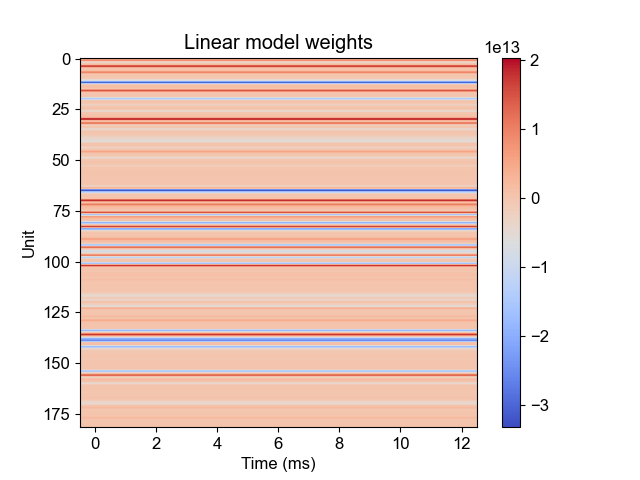

In [11]:
plt.figure()
plt.imshow(model.coef_, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Unit')
plt.title('Linear model weights')
plt.show()

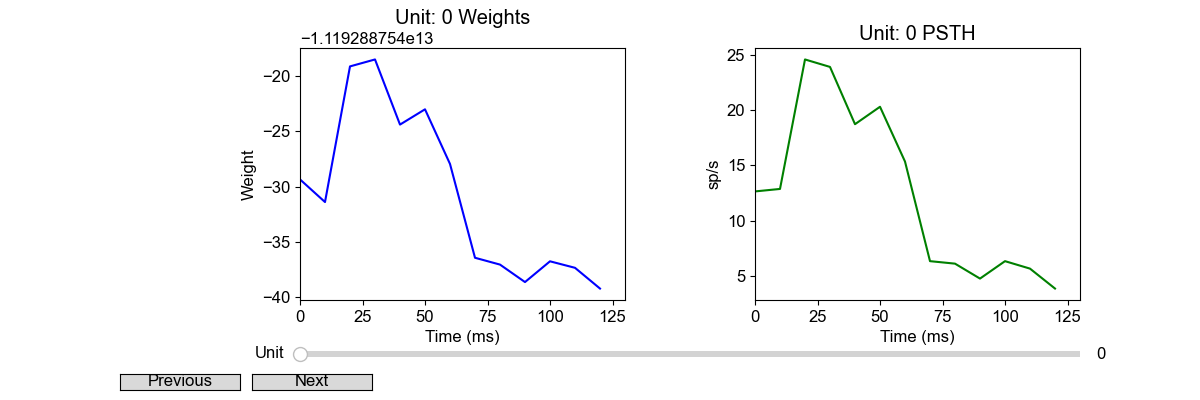

In [12]:
# I want to make an interactive line plot of a unit's weight across time
# and also plot the PSTH for each unit to compare the weights with the actual activity

from matplotlib.widgets import Slider, Button
fig, (ax_weights, ax_psth) = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.25, bottom=0.25, wspace=0.4)
axcolor = 'lightgoldenrodyellow'
axunit = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sunit = Slider(axunit, 'Unit', 0, n_units-1, valinit=0, valstep=1)

# Add buttons for navigating units
axprev = plt.axes([0.1, 0.025, 0.1, 0.04])
axnext = plt.axes([0.21, 0.025, 0.1, 0.04])
bprev = Button(axprev, 'Previous')
bnext = Button(axnext, 'Next')

def update(val):
    unit = int(sunit.val)
    ax_weights.clear()
    ax_weights.plot(np.arange(0, 130, 10), model.coef_[unit, :], color='blue')
    ax_weights.set_xlabel('Time (ms)')
    ax_weights.set_ylabel('Weight')
    ax_weights.set_title(f'Unit: {unit} Weights')
    ax_weights.set_xlim(0, 130)

    ax_psth.clear()
    ax_psth.plot(np.arange(0, 130, 10), np.mean(pop_peth[unit, :, :], axis=0), color='green')
    ax_psth.set_xlabel('Time (ms)')
    ax_psth.set_ylabel('sp/s')
    ax_psth.set_title(f'Unit: {unit} PSTH')
    ax_psth.set_xlim(0, 130)

    plt.draw()

def prev(event):
    current_val = sunit.val
    if current_val > 0:
        sunit.set_val(current_val - 1)

def next(event):
    current_val = sunit.val
    if current_val < n_units - 1:
        sunit.set_val(current_val + 1)

sunit.on_changed(update)
bprev.on_clicked(prev)
bnext.on_clicked(next)
update(0)  # Initial plot
plt.show()
